# CS188 Assignment 1-2: K-Nearest Neighbors (k-NN) 

Before we start, please put your name and UD in following format

: Firstname LASTNAME, #00000000   //   e.g.) Yining Hong, #000000000

**Your Answer:**   
Kevin TANG, #805419480

In this notebook you will implement a K-Nearest Neighbors classifier on the TinyPlaces dataset you created.

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

You will first focus on binary classification, then we will switch to multi-class classification.

You will first use raw pixel values as inputs, and then play with feature extraction. 

Since the test set of MiniPlaces is not public, and in this script we use cross-validation (so we do not need a validation set). Therefore, we use the validation set that we prepared for testing.  

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 188 folder and put all the files under A1 folder, then '188/Assignment1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '188/Assignment1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'kevintang2023@ucla.edu/Documents/Classes/2022W/CS188/Workspace/Assignment1'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['README.md', 'categories_tinyplaces.txt', 'cs188', '__pycache__', 'train.txt', 'val.txt', 'data', 'tinyplaces_creator.py', 'data_loader.ipynb', 'regression.ipynb', 'regression.py', 'knn.py', 'knn.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from knn.py!
```

as well as the last edit time for the file `pytorch101.py`.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from knn import hello
hello()

knn_path = os.path.join(GOOGLE_DRIVE_PATH, 'knn.py')
knn_edit_time = time.ctime(os.path.getmtime(knn_path))
print('knn.py last edited on %s' % knn_edit_time)

Hello from knn.py!
knn.py last edited on Sun Jan 23 20:41:09 2022


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import torch
import torchvision
import cs188
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

# K-Nearest Neighbors (k-NN) Binary Classification

## Compute distances: Naive implementation
Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Compute the (squared Euclidean) distances between all training examples and all test examples
2. Given these distances, for each test example find its k nearest neighbors and have them vote for the label to output

Lets begin with computing the distance matrix between all training and test examples. First we will implement a naive version of the distance computation, using explicit loops over the training and test sets. In the file `knn.py`, implement the function `compute_distances_two_loops`.

**NOTE: When implementing distance functions for this assignment, you may not use functions `torch.norm` or `torch.dist` (or their instance method variants `x.norm` / `x.dist`); you may not use any functions from `torch.nn` or `torch.nn.functional`.**

In [ ]:
from knn import compute_distances_two_loops

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH)

dists = compute_distances_two_loops(x_train, x_test)
print('dists has shape: ', dists.shape)

dists has shape:  torch.Size([10000, 1000])


As a visual debugging step, we can visualize the distance matrix, where each row is a test example and each column is a training example.

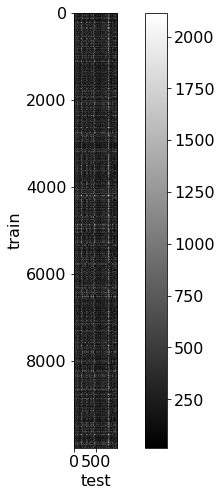

In [ ]:
plt.imshow(dists.cpu().numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('test')
plt.ylabel('train')
plt.show()

## Compute distances: Vectorization
Our implementation of the distance computation above is fairly inefficient since it uses nested Python loops over the training and test sets.

When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing your own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate your code.

The process of eliminating explict loops from your code is called **vectorization**. Sometimes it is straighforward to vectorize code originally written with loops; other times vectorizing requires thinking about the problem in a new way. We will use vectorization to improve the speed of our distance computation function.

As a first step toward vectorizing our distance computation, you will implement a version that uses only a single Python loop over the training data. In the file `knn.py`, complete the implementation of the function `compute_distances_one_loop`.

We can check the correctness of our one-loop implementation by comparing it with our two-loop implementation on some randomly generated data.

Note that we do the comparison with 64-bit floating points for increased numeric precision.

In [ ]:
from knn import compute_distances_one_loop
from knn import compute_distances_two_loops

torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_one = compute_distances_one_loop(x_train_rand, x_test_rand)
dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
difference = (dists_one - dists_two).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
    print('Good! The distance matrices match')
else:
    print('Uh-oh! The distance matrices are different')

Difference:  0.0
Good! The distance matrices match


You will now implement a fully vectorized version of the distance computation function
that does not use any Python loops. In the file `knn.py`, implement the function `compute_distances_no_loops`.

As before, we can check the correctness of our implementation by comparing the fully vectorized version against the original naive version:

In [ ]:
from knn import compute_distances_two_loops
from knn import compute_distances_no_loops

torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
dists_none = compute_distances_no_loops(x_train_rand, x_test_rand)
difference = (dists_two - dists_none).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

Difference:  1.7740975820862477e-11
Good! The distance matrices match


We can now compare the speed of our three implementations. If you've implemented everything properly, the one-loop implementation should take less than 4 seconds to run, and the fully vectorized implementation should take less than 0.1 seconds to run.

In [ ]:
import time
from knn import compute_distances_two_loops
from knn import compute_distances_one_loop
from knn import compute_distances_no_loops

def timeit(f, *args):
    tic = time.time()
    f(*args) 
    toc = time.time()
    return toc - tic

torch.manual_seed(0)
x_train_rand = torch.randn(500, 3, 32, 32)
x_test_rand = torch.randn(500, 3, 32, 32)

two_loop_time = timeit(compute_distances_two_loops, x_train_rand, x_test_rand)
print('Two loop version took %.2f seconds' % two_loop_time)

one_loop_time = timeit(compute_distances_one_loop, x_train_rand, x_test_rand)
speedup = two_loop_time / one_loop_time
print('One loop version took %.2f seconds (%.1fX speedup)'
      % (one_loop_time, speedup))

no_loop_time = timeit(compute_distances_no_loops, x_train_rand, x_test_rand)
speedup = two_loop_time / no_loop_time
print('No loop version took %.2f seconds (%.1fX speedup)'
      % (no_loop_time, speedup))

Two loop version took 3.87 seconds
One loop version took 1.07 seconds (3.6X speedup)
No loop version took 0.02 seconds (165.5X speedup)


## Predict labels
Now that we have a method for computing distances between training and test examples, we need to implement a function that uses those distances together with the training labels to predict labels for test samples.

#### Image Retrieval

We first implement the function that retrieves the indices of top k relevant images. In the file `knn.py`, implement the function `predict_labels` to output indices first. 



We first work on a toy example of 1D data to test `predict_labels` to output the correct indices. If your implementation is correct, should output tensor([[1, 2, 0]]).

In [ ]:
from knn import predict_labels

torch.manual_seed(0)
dists = torch.tensor([
    [0.3, 0.4, 0.1],
    [0.1, 0.5, 0.5],
    [0.4, 0.1, 0.2],
    [0.2, 0.2, 0.4],
    [0.5, 0.3, 0.3],
])
y_train = torch.tensor([0, 1, 0, 1, 2])
indices, _ = predict_labels(dists, y_train, k=1)
print (indices)

tensor([[1, 2, 0]])


Then we implement the `retrieval` function in `KnnClassifier` to retrieve 2D images. We use an example from the TinyPlaces dataset. We visualize the 5 most relevant images from the training dataset giving a sample from the test set.

this is the original sample from the test set of outdoor scene


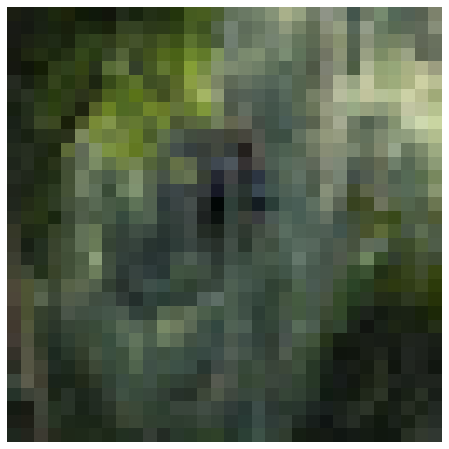

this is the most relevant images from the training set to an outdoor sample


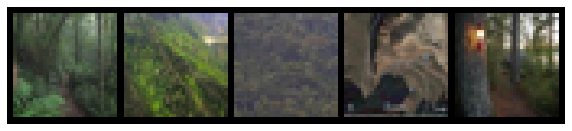

and their labels
['outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor']


In [ ]:
from knn import KnnClassifier

num_classes = 2
classes_list = ['indoor', 'outdoor']

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH)

classifier = KnnClassifier(x_train, y_train)

indices = classifier.retrieval(x_test[:1], k=5)

print ("this is the original sample from the test set of %s scene"%classes_list[y_test[0].int()])
plt.imshow(cs188.tensor_to_image(x_test[0]))
plt.axis('off')
plt.show()

samples = []
labels = []

for idx in indices:
  samples.append(x_train[idx].squeeze())
  labels.append(y_train[idx].squeeze().int())


print ("this is the most relevant images from the training set to an %s sample"%classes_list[y_test[0].int()])
img = torchvision.utils.make_grid(samples, nrow=5)
plt.imshow(cs188.tensor_to_image(img))
plt.axis('off')
plt.show()

print ("and their labels")
print ([classes_list[label] for label in labels])

If your implementation is right, you should see that most of the images belong to the same group.

#### Predict Labels
The next step is to output the labels via retrieved indices. We further implement `predict_labels` to output the labels for an example in the test set. Here we use a toy test. 

In [ ]:
from knn import predict_labels

torch.manual_seed(0)
dists = torch.tensor([
    [0.3, 0.4, 0.1],
    [0.1, 0.5, 0.5],
    [0.4, 0.1, 0.2],
    [0.2, 0.2, 0.4],
    [0.5, 0.3, 0.3],
])
y_train = torch.tensor([0, 1, 0, 1, 2])
y_pred_expected = torch.tensor([1, 0, 0])
_, y_pred = predict_labels(dists, y_train, k=3)
correct = y_pred.tolist() == y_pred_expected.tolist()
print('Correct: ', correct)

Correct:  True


Then we use an example from the TinyPlaces dataset. 

In [ ]:
from knn import KnnClassifier

num_classes = 2

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH)

classifier = KnnClassifier(x_train, y_train)

y_pred_test = classifier.predict(x_test[:1], k=10).squeeze()

correct = y_pred_test.tolist() == y_test[0].tolist()
print('Correct: ', correct)

Correct:  True


## Image Classification
We can now use the exact same KNN code to perform image classification on TinyPlaces!

Now lets put everything together and test our K-NN clasifier on the full TinyPlaces, using k=1:

In [ ]:
from knn import KnnClassifier

torch.manual_seed(0)
x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, use_gpu=True)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Got 687 / 1000 correct; accuracy is 68.70%


68.7

Now lets increase to k=10. You should see a slightly higher accuracy than k=1:

In [ ]:
from knn import KnnClassifier

torch.manual_seed(0)
x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=10)

Got 649 / 1000 correct; accuracy is 64.90%


64.9

## Cross-validation
We have not implemented the full k-Nearest Neighbor classifier. We will use **cross-validation** to set this hyperparameter in a more principled manner.

In the file `knn.py`, implement the function `knn_cross_validate` to perform cross-validation on k.

In [ ]:
from knn import knn_cross_validate

torch.manual_seed(0)

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH)

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

Got 1285 / 2000 correct; accuracy is 64.25%
Got 1310 / 2000 correct; accuracy is 65.50%
Got 1314 / 2000 correct; accuracy is 65.70%
Got 1273 / 2000 correct; accuracy is 63.65%
Got 1305 / 2000 correct; accuracy is 65.25%
Got 1336 / 2000 correct; accuracy is 66.80%
Got 1311 / 2000 correct; accuracy is 65.55%
Got 1370 / 2000 correct; accuracy is 68.50%
Got 1311 / 2000 correct; accuracy is 65.55%
Got 1298 / 2000 correct; accuracy is 64.90%
Got 1333 / 2000 correct; accuracy is 66.65%
Got 1294 / 2000 correct; accuracy is 64.70%
Got 1395 / 2000 correct; accuracy is 69.75%
Got 1326 / 2000 correct; accuracy is 66.30%
Got 1314 / 2000 correct; accuracy is 65.70%
Got 1369 / 2000 correct; accuracy is 68.45%
Got 1356 / 2000 correct; accuracy is 67.80%
Got 1418 / 2000 correct; accuracy is 70.90%
Got 1363 / 2000 correct; accuracy is 68.15%
Got 1371 / 2000 correct; accuracy is 68.55%
Got 1292 / 2000 correct; accuracy is 64.60%
Got 1258 / 2000 correct; accuracy is 62.90%
Got 1348 / 2000 correct; accurac

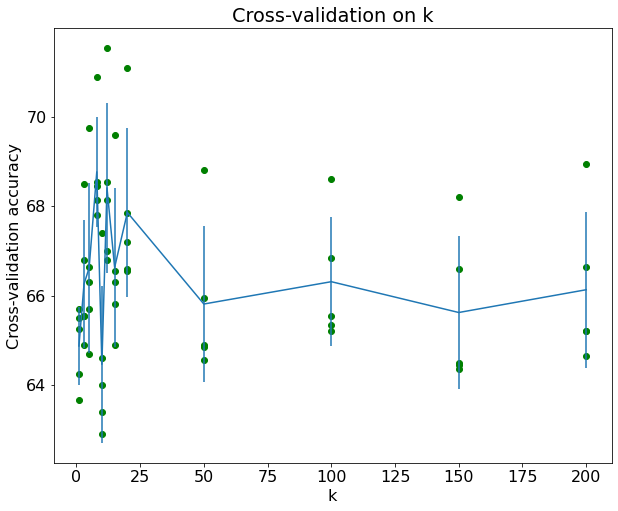

In [ ]:
ks, means, stds = [], [], []
torch.manual_seed(0)
for k, accs in sorted(k_to_accuracies.items()):
  plt.scatter([k] * len(accs), accs, color='g')
  ks.append(k)
  means.append(statistics.mean(accs))
  stds.append(statistics.stdev(accs))
plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

Now we can use the results of cross-validation to select the best value for k, and rerun the classifier on our full set of training examples. 
(I can get an accuracy of 70%. Try to beat me!)

In [ ]:
from knn import KnnClassifier
from knn import knn_get_best_k

best_k = 1
torch.manual_seed(0)

best_k = knn_get_best_k(k_to_accuracies)
print('Best k is ', best_k)

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Best k is  8
Got 707 / 1000 correct; accuracy is 70.70%


70.7

## Feature Extraction
Now, instead of using raw pixel values as input, we will extract the features from the images. We have implemented this for you. Just set ``feature`` to ``True`` when calling tinyplaces. We use histograms of colors as features. You should go through the codes in data.py and understand how feature extraction goes. 

Likewise, we will first perform cross validation

In [ ]:
import cs188
from knn import knn_cross_validate

torch.manual_seed(0)

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, feature=True, use_gpu=True)

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

Got 1404 / 2000 correct; accuracy is 70.20%
Got 1403 / 2000 correct; accuracy is 70.15%
Got 1408 / 2000 correct; accuracy is 70.40%
Got 1425 / 2000 correct; accuracy is 71.25%
Got 1397 / 2000 correct; accuracy is 69.85%
Got 1470 / 2000 correct; accuracy is 73.50%
Got 1482 / 2000 correct; accuracy is 74.10%
Got 1463 / 2000 correct; accuracy is 73.15%
Got 1487 / 2000 correct; accuracy is 74.35%
Got 1450 / 2000 correct; accuracy is 72.50%
Got 1497 / 2000 correct; accuracy is 74.85%
Got 1486 / 2000 correct; accuracy is 74.30%
Got 1500 / 2000 correct; accuracy is 75.00%
Got 1514 / 2000 correct; accuracy is 75.70%
Got 1491 / 2000 correct; accuracy is 74.55%
Got 1506 / 2000 correct; accuracy is 75.30%
Got 1478 / 2000 correct; accuracy is 73.90%
Got 1482 / 2000 correct; accuracy is 74.10%
Got 1503 / 2000 correct; accuracy is 75.15%
Got 1488 / 2000 correct; accuracy is 74.40%
Got 1535 / 2000 correct; accuracy is 76.75%
Got 1522 / 2000 correct; accuracy is 76.10%
Got 1500 / 2000 correct; accurac

Using features, I can achieve 74% accuracy. What about you?

In [ ]:
from knn import KnnClassifier
from knn import knn_get_best_k

best_k = 1
torch.manual_seed(0)

best_k = knn_get_best_k(k_to_accuracies)    
print('Best k is ', best_k)

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, feature=True)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Best k is  10
Got 745 / 1000 correct; accuracy is 74.50%


74.5

### Write down your understanding of feature extraction, and how it affects the performances.

**Your Answer**: My understanding is that traditionally, you use the entire image/pixel data as input, whereas with feature extraction, we can do preprocessing and use some derived "feature" from the original image data as the input instead. By doing this processing (e.g, deriving a color histogram) before we run any training on the data, we can significantly reduce the input size, which of course, has the potential to increase performance dramatically, far more than the cost of doing the preprocessing itself.

Additionally, by choosing an appropriate feature to extract, we may be "helping" our classifier in the sense that we are removing some noise in the data, which can again improve performance and accuracy.

However, if we choose a bad or suboptimal feature to extract, we may lose useful data and reduce accuracy. Thus, there is that tradeoff of performance vs accuracy.


# KNN (Multi-Class Classification)

Now we we will switch to multi-class classification. Instead of classifying indoor-outdoor scenes, we will have all the 20 sub-categories for classification.

You do not need to change your implementations here. Just set ``binary`` to ``False`` when calling tinyplaces loader. 

We will also go through cross validation first.

In [ ]:
import cs188
from knn import knn_cross_validate

torch.manual_seed(0)

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, binary=False)

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

Got 249 / 2000 correct; accuracy is 12.45%
Got 270 / 2000 correct; accuracy is 13.50%
Got 265 / 2000 correct; accuracy is 13.25%
Got 253 / 2000 correct; accuracy is 12.65%
Got 244 / 2000 correct; accuracy is 12.20%
Got 257 / 2000 correct; accuracy is 12.85%
Got 267 / 2000 correct; accuracy is 13.35%
Got 273 / 2000 correct; accuracy is 13.65%
Got 252 / 2000 correct; accuracy is 12.60%
Got 261 / 2000 correct; accuracy is 13.05%
Got 291 / 2000 correct; accuracy is 14.55%
Got 288 / 2000 correct; accuracy is 14.40%
Got 292 / 2000 correct; accuracy is 14.60%
Got 272 / 2000 correct; accuracy is 13.60%
Got 291 / 2000 correct; accuracy is 14.55%
Got 283 / 2000 correct; accuracy is 14.15%
Got 303 / 2000 correct; accuracy is 15.15%
Got 303 / 2000 correct; accuracy is 15.15%
Got 283 / 2000 correct; accuracy is 14.15%
Got 287 / 2000 correct; accuracy is 14.35%
Got 287 / 2000 correct; accuracy is 14.35%
Got 308 / 2000 correct; accuracy is 15.40%
Got 311 / 2000 correct; accuracy is 15.55%
Got 292 / 2

For multi-class classification, I can get 17% accuracy. What about you?

In [ ]:
from knn import KnnClassifier
from knn import knn_get_best_k

best_k = 1
torch.manual_seed(0)

best_k = knn_get_best_k(k_to_accuracies)    
print('Best k is ', best_k)

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, binary=False)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Best k is  15
Got 163 / 1000 correct; accuracy is 16.30%


16.3

this is the original sample from the test set of bathroom scene


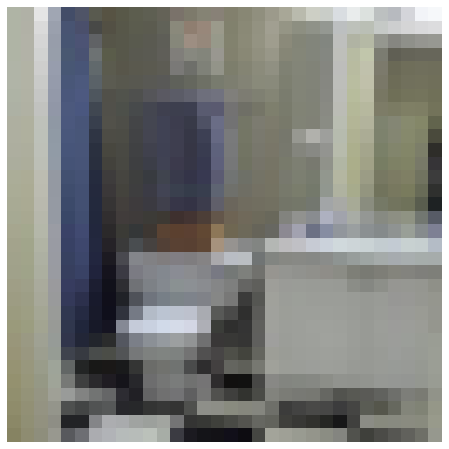

this is the most relevant images from the training set to an bathroom sample


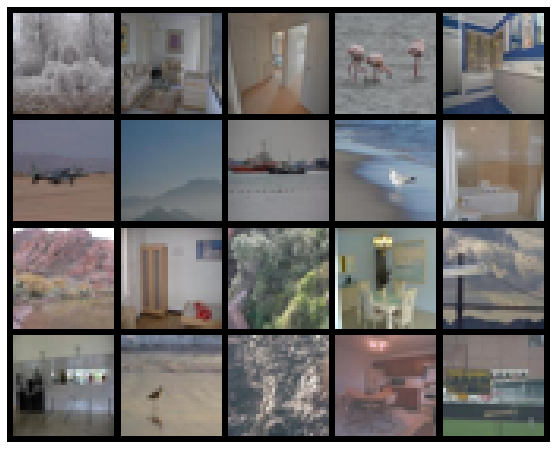

and their labels
['rainforest', 'living_room', 'bedroom', 'coast', 'bathroom', 'mountain', 'mountain', 'coast', 'coast', 'bathroom', 'canyon', 'bedroom', 'rainforest', 'dining_room', 'bridge', 'lobby', 'coast', 'coast', 'kitchen', 'baseball_field']


In [ ]:
indices = classifier.retrieval(x_test[:1], k=20)

classes_list = ['bathroom', 'bedroom', 'bookstore', 'classroom', 'dining_room', 'food_court', 'kitchen', 'lobby', 'living_room', 'office', 'baseball_field', 'bridge', 'campsite', 'canyon', 'coast', 'fountain', 'highway', 'playground', 'mountain', 'rainforest']
print ("this is the original sample from the test set of %s scene"%classes_list[y_test[0].int()])
plt.imshow(cs188.tensor_to_image(x_test[0]))
plt.axis('off')
plt.show()

samples = []
labels = []

for idx in indices:
  samples.append(x_train[idx].squeeze())
  labels.append(y_train[idx].squeeze().int())


print ("this is the most relevant images from the training set to an %s sample"%classes_list[y_test[0].int()])
img = torchvision.utils.make_grid(samples, nrow=5)
plt.imshow(cs188.tensor_to_image(img))
plt.axis('off')
plt.show()

print ("and their labels")
print ([classes_list[label] for label in labels])